In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
# import math
import importlib as imp
import random

/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/raeholcomb/.lightkurve/cache. Please move all the files in the legacy directory /Users/raeholcomb/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS, Sip
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.mast import Catalogs

In [3]:
import imp
imp.reload(utils)

/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_53619/2092303083.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'utils' from '/Users/raeholcomb/Documents/GitHub/pandora-me/utils.py'>

In [4]:
import pandorasat as psat
ps = psat.PandoraSat()
vda = ps.VISDA
vda.naxis2

<Quantity 2048. pix>

## Set up catalog and WCS

In [5]:
# Start with an RA, DEC, and Roll
random.seed(10)
ra = random.uniform(0,360) * u.deg
dec = random.uniform(-90,90) * u.deg
roll = Angle(random.uniform(0,360) * u.deg)

print(ra, dec, roll)

205.70493408836887 deg -12.799970158479368 deg 208d06m46.32627027s


In [6]:
# make wcs0
wcs0 = utils.get_wcs(
    vda, ra, dec, 
    vda.naxis1.value/2, vda.naxis2.value/2,
    roll,
    order = 3,
    xreflect = False,
    yreflect = False,    
)

In [7]:
# query gaia catalog
ref_coords = SkyCoord(ra, dec, unit="deg")
radius = vda.naxis1 * (vda.pixel_scale) * (np.sqrt(2) * 1.05)  # build in a 5% buffer into the radius we're querying
gaia_cat = Table(utils.get_sky_catalog(ra=ref_coords.ra.deg, dec=ref_coords.dec.deg, radius=radius))


In [8]:
print(len(gaia_cat))
gaia_cat[:5]

2518


jmag,bmag,gmag,gflux,ang_sep,teff,logg,RUWE,coords,source_id
,,,,deg,K,,,"deg,deg,pc",
float32,float32,float32,float64,float64,float32,float32,float32,SkyCoord,str28
16.283,18.516214,17.897676,1305.7981465706366,0.01848963559005252,4549.6606,4.449,1.0695448,"205.68597781513913,-12.800747381458,3739.9215240743106",Gaia DR3 3607281321821203072
16.207,19.873108,18.867043,534.7243913010286,0.02041714045419792,nan,nan,1.1434982,"205.70630517237169,-12.82037763568996,1486.4540901544574",Gaia DR3 3607281051238439040
15.134,17.25573,16.686472,3984.356172173656,0.020740839286126276,4607.5674,4.6656,0.98938024,"205.72531658140912,-12.805797969367822,1056.1216949986017",Gaia DR3 3607281085598178048
14.955,17.118235,16.54626,4533.595131901215,0.024360583341749373,4584.934,4.3823,1.0031124,"205.68230453447083,-12.810318565194262,1495.5477916638251",Gaia DR3 3607279844352448768
15.0,17.590702,16.871096,3361.3093888118865,0.028736731542184757,4501.3496,4.6205,1.0440506,"205.71826087165806,-12.77436601400027,1051.029482071635",Gaia DR3 3607281497915039232


In [8]:
# reformat the catalog
cat = gaia_cat.copy()
cat['ra'] = gaia_cat['coords'].ra
cat['dec'] = gaia_cat['coords'].dec
cat = cat[[ 'ra', 'dec', 'gmag', 'gflux', 'coords', 'source_id',]]

# redo the source_id column
cat['source_id'] = np.arange(len(cat)).astype(int)

# add in the pixel locations
pix_x, pix_y = wcs0.all_world2pix(cat['ra'], cat['dec'], 0)
cat['pix_x'] = pix_x
cat['pix_y'] = pix_y

cat[:3]

ra,dec,gmag,gflux,coords,source_id,pix_x,pix_y
deg,deg,,,"deg,deg,pc",,,
float64,float64,float32,float64,SkyCoord,int64,float64,float64
205.68597773205101,-12.80074751896448,17.897676,1305.7981465706366,"205.68597773205101,-12.80074751896448,3739.9215240712706",0,1099.9429683775327,985.9653389587245
205.70630538162854,-12.82037787184686,18.867043,534.7243913010286,"205.70630538162854,-12.82037787184686,1486.454090152625",1,1061.9398310380734,1108.985055210085
205.72531632898264,-12.805798074454266,16.686472,3984.356172173656,"205.72531632898264,-12.805798074454266,1056.1216949979223",2,954.7667656039324,1089.9529050976548


/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_53619/2526105519.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


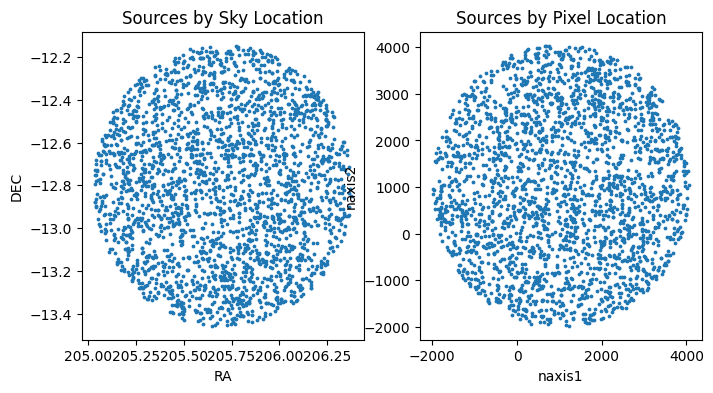

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8,4])
ax1.scatter(gaia_cat['coords'].ra,gaia_cat['coords'].dec, s=3)
ax1.set_title('Sources by Sky Location')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

ax2.scatter(cat['pix_x'],cat['pix_y'], s=3)
ax2.set_title('Sources by Pixel Location')
ax2.set_xlabel('naxis1')
ax2.set_ylabel('naxis2')
fig.show()

## Set up affine transforms

In [10]:
def make_affine_matrix(
        xreflect: bool = False,
        yreflect: bool = False,
        scale: tuple = (1,1),
        rotate: float = 0,
        shear: tuple = (0,0),
        translate: tuple = (0,0),
) -> np.array :
    """Given some affine transformations, constructs the 3x3 matrix needed to perform them."""

    # identity matrix
    M = np.array([[1,0,0],[0,1,0],[0,0,1]])

    # reflection
    if xreflect:
        M = M.dot(np.array([[1,0,0],[0,-1,0],[0,0,1]]))
    if yreflect:
        M = M.dot(np.array([[-1,0,0],[0,1,0],[0,0,1]]))

    # scale
    M = M.dot(np.array([[scale[0],0,0],[0,scale[1],0],[0,0,1]]))

    # rotate
    M = M.dot(np.array([[np.cos(rotate),-np.sin(rotate),0],[np.sin(rotate),np.cos(rotate),0],[0,0,1]]))

    # shear
    M = M.dot(np.array([[1,shear[0],0],[shear[1],1,0],[0,0,1]]))

    # translate
    M = M.dot(np.array([[1,0,translate[0]],[0,1,translate[1]],[0,0,1]]))

    return M


In [11]:
make_affine_matrix(scale=(.5,1), shear=(.1,-.3))

array([[ 0.5 ,  0.05,  0.  ],
       [-0.3 ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ]])

In [12]:
def affine_transform_xy(
        x: np.array, y: np.array,
        crpix1: int = None,
        crpix2: int = None,
        M: np.array = None,
        xreflect: bool = False,
        yreflect: bool = False,
        scale: tuple = (1,1),
        rotate: float = 0,
        shear: tuple = (0,0),
        translate: tuple = (0,0),
) -> (np.array, np.array) :
    """Docstring.
    Rotation is in RADIANS.
    Scale should always be positive.
    If the affine matrix M is provided, then it overrides all the other keywords."""
    if len(x) != len(y):
        raise ValueError('x and y need to be the same length')
        return
    
    # construct the matrix
    if M is None:
        M = make_affine_matrix(xreflect, yreflect, scale, rotate, shear, translate)
    
    # center the coordinate matrix on the crpix
    coord_mat = np.array([x - crpix1, y - crpix2, np.ones_like(x)])

    # calculate
    output = M.dot(coord_mat)

    # undo the translation to the crpix
    x_new = output[0,:] + crpix1
    y_new = output[1,:] + crpix2

    return x_new, y_new



In [15]:
# # affine transform testing
# c1 = .25
# c2 = .25
# # x1, y1 = affine_transform_xy(x, y, crpix1=c1, crpix2=c2, xreflect=True, yreflect=False)
# # x1, y1 = affine_transform_xy(x, y, crpix1=c1, crpix2=c2, scale=(.5,.5))
# # x1, y1 = affine_transform_xy(x, y, crpix1=c1, crpix2=c2, rotate=np.pi/2)
# # x1, y1 = affine_transform_xy(x, y, crpix1=c1, crpix2=c2, shear=(.5,-.5))
# # x1, y1 = affine_transform_xy(x, y, crpix1=c1, crpix2=c2, translate=(-.2,.1))
# x1, y1 = affine_transform_xy(x, y, crpix1=c1, crpix2=c2, 
#                              M=np.array([[ 0.5 ,  0.05,  0.  ],[-0.3 ,  1.  ,  0.  ],[ 0.  ,  0.  ,  1.  ]]))

    
# plt.scatter(x, y, s=15)
# plt.scatter(x1, y1, s=15)
# plt.scatter(c1, c2, c='r', s=55, marker='x')
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.show()

NameError: name 'x' is not defined

In [13]:
# choose some slight affine transformations
# ranges
# reflections: true or false <-- actually probably don't need
# scale: +/- .05 
# rotate: +/- 5 deg?
# shear: +/- .05
# translate: +- 5" 

adict = {
    'xreflect': False,
    'yreflect': False,
    'scale': (random.uniform(.95, 1.05), random.uniform(.95, 1.05)),
    'rotate': random.uniform(0, 5) * np.pi / 180,
    'shear': (random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05)),
    'translate': (random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05)),
}

print(adict)


{'xreflect': False, 'yreflect': False, 'scale': (0.9706098232139502, 1.031332125135732), 'rotate': 0.07187168754248258, 'shear': (0.015347253390117582, -0.03397704434811803), 'translate': (0.0020669359639924542, -0.01722271883779069)}


In [14]:
# make M matrix
M = make_affine_matrix(**adict)
print(M)

# make warped catalog
cat_warp = cat.copy()
x1, y1 = affine_transform_xy(cat['pix_x'].value, cat['pix_y'].value, crpix1=vda.naxis1.value/2, crpix2=vda.naxis2.value/2, M=M)

# need to convert from pix back to RA/DEC
ra1, dec1 = wcs0.all_pix2world(x1, y1, 0)
cat_warp['pix_x'] = x1
cat_warp['pix_y'] = y1
cat_warp['ra'] = ra1
cat_warp['dec'] = dec1
cat_warp['coords'] = SkyCoord(ra1,dec1, unit="deg")

[[ 0.97047222 -0.05484159  0.00295043]
 [ 0.03910863  1.02980619 -0.01765523]
 [ 0.          0.          1.        ]]


/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_53619/3854825484.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


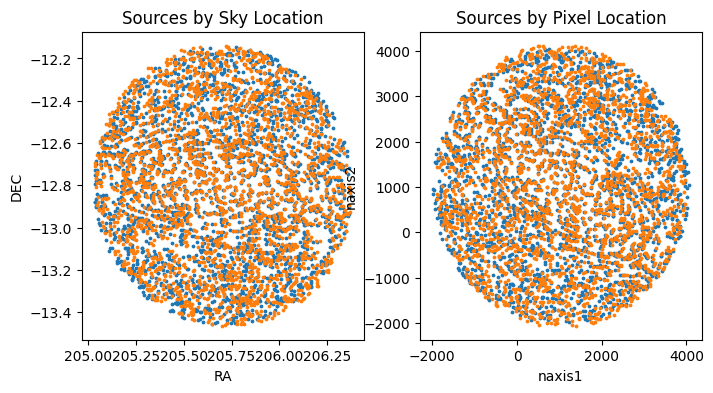

In [15]:
# compare the warped and unwarped catalogs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8,4])
ax1.scatter(cat['coords'].ra,cat['coords'].dec, s=3)
ax1.scatter(cat_warp['coords'].ra,cat_warp['coords'].dec, s=3)
ax1.set_title('Sources by Sky Location')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

ax2.scatter(cat['pix_x'],cat['pix_y'], s=3)
ax2.scatter(cat_warp['pix_x'],cat_warp['pix_y'], s=3)
ax2.set_title('Sources by Pixel Location')
ax2.set_xlabel('naxis1')
ax2.set_ylabel('naxis2')
fig.show()

In [20]:
range(int(vda.naxis1.value))

range(0, 2048)

In [44]:
# pix_x[0]
np.shape(model_grid)

(2048, 2048, 2)

## Create Scene

In [16]:
import numpy as np


# We'll use this for apertures
def gaussian_2d(x, y, mu_x, mu_y, sigma_x=2, sigma_y=2):
    """
    Compute the value of a 2D Gaussian function.

    Parameters:
    x (float): x-coordinate.
    y (float): y-coordinate.
    mu_x (float): Mean of the Gaussian in the x-direction.
    mu_y (float): Mean of the Gaussian in the y-direction.
    sigma_x (float): Standard deviation of the Gaussian in the x-direction.
    sigma_y (float): Standard deviation of the Gaussian in the y-direction.

    Returns:
    float: Value of the 2D Gaussian function at (x, y).
    """
    part1 = 1 / (2 * np.pi * sigma_x * sigma_y)
    part2 = np.exp(
        -((x - mu_x) ** 2 / (2 * sigma_x**2) + (y - mu_y) ** 2 / (2 * sigma_y**2))
    )
    return part1 * part2

In [18]:
# test normalization

mean_x, mean_y = np.random.uniform(0, 2048, size=(2, 1000))
std_x, std_y = 2, 2
image_shape = (2048, 2048)
nstddevs = 8
R, C = np.mgrid[-nstddevs : nstddevs + 1, -nstddevs : nstddevs + 1]

data = gaussian_2d(
    R[:, :, None],
    C[:, :, None],
    mean_x % 1,
    mean_y % 1,
    np.atleast_1d(std_x),
    np.atleast_1d(std_y),
)



(17, 17, 1000)
0.9999155027867895


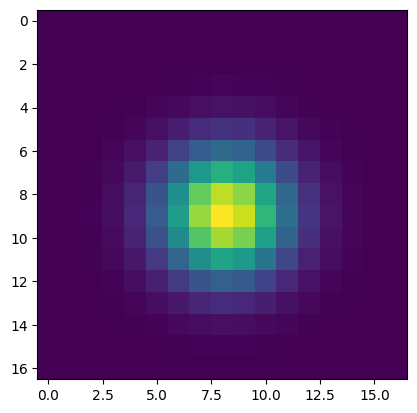

In [25]:
# check gaussian output
# print(np.sum)
print(data.shape)
print(np.sum(data[:,:,0].ravel()))
plt.imshow(data[:,:,0])
plt.show()

In [24]:
import sys
sys.path.insert(0, '../pandora-psf/src')
import pandorapsf
from scipy import sparse

# SparseWarp3D = pandorapsf.scene.SparseWarp3D
SparseWarp3D = utils.SparseWarp3D


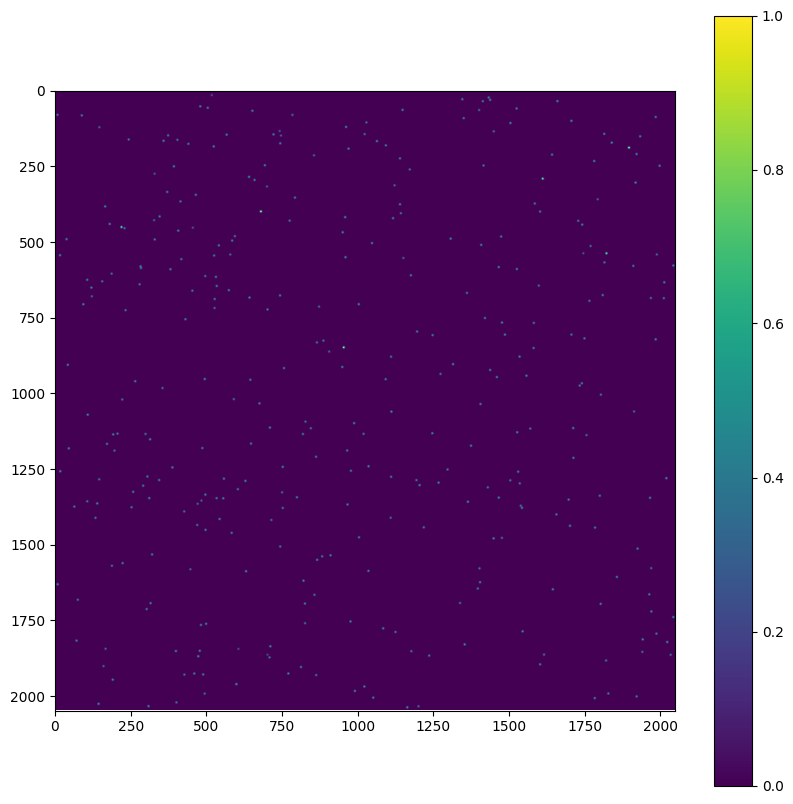

In [25]:
# undistorted scene
# from pandorapsf import SparseWarp3d
# from scipy import sparse

# use the catalog

mean_x, mean_y = cat['pix_x'], cat['pix_y']
std_x, std_y = 2, 2
image_shape = (2048, 2048)
nstddevs = 8
R, C = np.mgrid[-nstddevs : nstddevs + 1, -nstddevs : nstddevs + 1]

data = utils.gaussian_2d(
    R[:, :, None],
    C[:, :, None],
    mean_x % 1,
    mean_y % 1,
    np.atleast_1d(std_x),
    np.atleast_1d(std_y),
)


s = SparseWarp3D(
    data,
    R[:, :, None] + np.floor(mean_x),
    C[:, :, None] + np.floor(mean_y),
    image_shape,
)

# True flux
w = cat['gmag'].value
fake_data = s.dot(w)[0]

plt.figure(figsize=(10, 10))
plt.imshow(fake_data, vmin=0, vmax=1)
plt.colorbar()

In [21]:
np.random.normal(size=mean_x.shape[0])
cat['gflux'].value

array([  1305.79814657,    534.7243913 ,   3984.35617217, ...,
         5252.52959057,  11837.06572504, 148141.76158553])

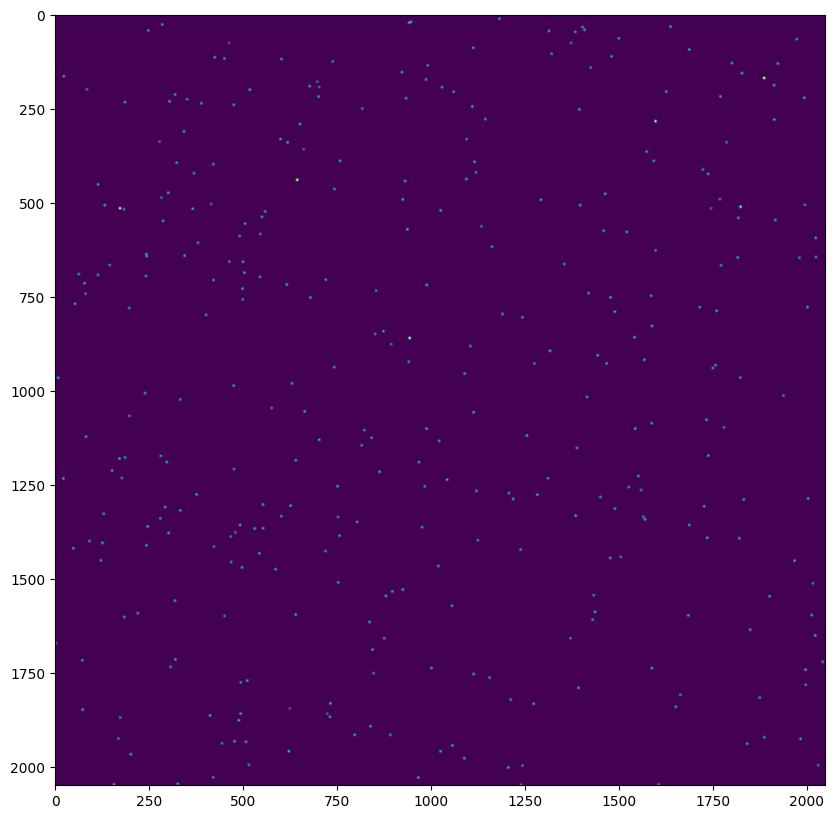

In [22]:
# distorted scene
mean_x, mean_y = cat_warp['pix_x'], cat_warp['pix_y']
std_x, std_y = 2, 2
image_shape = (2048, 2048)
nstddevs = 8
R, C = np.mgrid[-nstddevs : nstddevs + 1, -nstddevs : nstddevs + 1]

data = gaussian_2d(
    R[:, :, None],
    C[:, :, None],
    mean_x % 1,
    mean_y % 1,
    np.atleast_1d(std_x),
    np.atleast_1d(std_y),
)


s = SparseWarp3D(
    data,
    R[:, :, None] + np.floor(mean_x),
    C[:, :, None] + np.floor(mean_y),
    image_shape,
)

# True mag
w = cat_warp['gmag'].value
fake_data_warp = s.dot(w)[0]

plt.figure(figsize=(10, 10))
plt.imshow(fake_data_warp, vmin=0, vmax=.8)

In [27]:
fake_data.shape

(2048, 2048)

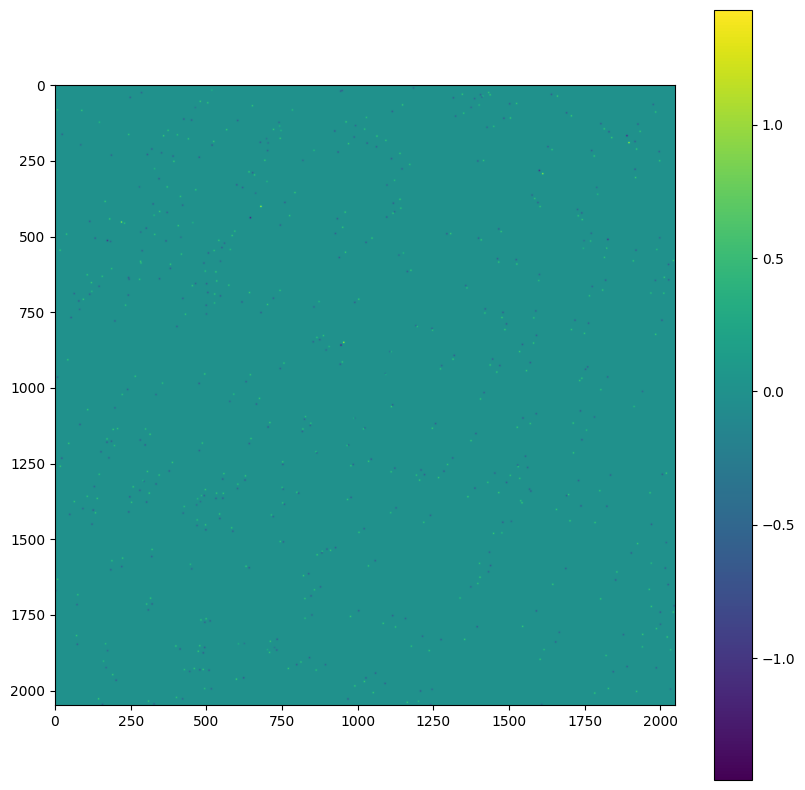

In [23]:
# examine the difference
plt.figure(figsize=(10, 10))
plt.imshow(fake_data-fake_data_warp)
plt.colorbar()
plt.show()

## Bundle into a FITS file

In [24]:
imp.reload(utils)

<module 'utils' from '/Users/raeholcomb/Documents/GitHub/pandora-me/utils.py'>

In [25]:
# let's make some fits files!
# Desired format
    # primary extension
    # image extension
    # true catalog extension (ra, dec, flux, pixel_row, pixel_column)
    # warped catalog extension (ra, dec, flux, pixel_row, pixel_column)
    # affine matrix extension (3, 3 matrix)

# hdu = fits.PrimaryHDU(n)

In [26]:
from copy import copy
from glob import glob

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.time import Time, TimeDelta

In [ ]:
# COPIED FROM BEN'S PANDORASIM, adjust later
# https://github.com/benhord/pandora-sim/blob/sim_tools_only/src/pandorasim/pandorasim.py
def save_to_FITS(
    data: np.ndarray,
    filename: str,
    primary_kwds: dict,
    image_kwds: dict,
    roitable: bool = False,
    roitable_kwds: dict | None = None,
    roi_data: np.ndarray | None = None,
    overwrite: bool = True,
):
    primary_hdu = fits.PrimaryHDU()

    for key, value in primary_kwds.items():
        primary_hdu.header[key] = value

    image_hdu = fits.ImageHDU(data)

    for key, value in image_kwds.items():
        image_hdu.header[key] = value

    hdu_list = [primary_hdu, image_hdu]

    if roitable:
        # table_hdu = fits.TableHDU(roi_data)
        table_hdu = fits.table_to_hdu(roi_data)

        for key, value in roitable_kwds.items():
            table_hdu.header[key] = value

        hdu_list.append(table_hdu)

    hdul = fits.HDUList(hdu_list)

    hdul.writeto(filename, overwrite=overwrite)

def save_visda(
    self,
    outfile: str = 'pandora_'+Time.now().strftime('%Y-%m-%dT%H:%M:%S')+'_l1_visda.fits',
    rois: bool = False,
    overwrite: bool = True,
):
    """Function to save FFIs in the FITS format"""
    if not hasattr(self, "ffis"):
        raise AttributeError('Please create FFIs first with .get_FFIs() command!')

    corstime = int(np.floor((self.obstime - Time("2000-01-01T12:00:00", scale='utc')).sec))
    finetime = int(corstime % 1 * 10**9 // 1)

    primary_kwds = {
        'EXTNAME': ('PRIMARY', 'name of extension'),
        'NEXTEND': (2, 'number of standard extensions'),
        'SIMDATA': (True, 'simulated data'),
        'SCIDATA': (False, 'science data'),
        'TELESCOP': ('NASA Pandora', 'telescope'),
        'INSTRMNT': ('VISDA', 'instrument'),
        'CREATOR': ('Pandora DPC', 'creator of this product'),
        'CRSOFTV': ('v'+str(__version__), 'creator software version'),
        'TARG_RA': (self.ra.value, 'target right ascension [deg]'),
        'TARG_DEC': (self.dec.value, 'target declination [deg]'),
        'FRMSREQD': (self.ffi_nframes, 'number of frames requested'),
        'FRMSCLCT': (self.ffi_nframes, 'number of frames collected'),
        'NUMCOAD': (1, 'number of frames coadded'),
        'FRMTIME': (self.ffi_nreads * self.VISDA.integration_time.value, 'time in each frame [s]'),
        'EXPDELAY': (-1, 'exposure time delay [ms]'),
        'RICEX': (-1, 'bit noise parameter for Rice compression'),
        'RICEY': (-1, 'bit noise parameter for Rice compression'),
        'CORSTIME': (corstime, 'seconds since the TAI Epoch (12PM Jan 1, 2000)'),
        'FINETIME': (finetime, 'nanoseconds added to CORSTIME seconds'),
    }

    if rois:
        n_arrs, frames, nrows, ncols = self.subarrays.shape

        # Find the next largest perfect square from the number of subarrays given
        next_square = int(np.ceil(np.sqrt(n_arrs)) ** 2)
        sq_sides = int(np.sqrt(next_square))

        # Pad the subarrays with addtional subarrays full of zeros up to the next perfect square
        subarrays = self.subarrays
        padding = np.zeros((next_square - n_arrs, frames, nrows, ncols), dtype=int)
        subarrays = np.append(subarrays, padding, axis=0)

        image_data = (subarrays.reshape(frames, sq_sides, sq_sides, nrows, ncols)
                        .swapaxes(2, 3)
                        .reshape(frames, sq_sides*nrows, sq_sides*ncols))

        roi_data = Table(self.VISDA.corners)

        roitable_kwds = {
            'NAXIS': (2, 'number of array dimensions'),
            'NAXIS1': (len(self.VISDA.corners[0]), 'length of dimension 1'),
            'NAXIS2': (len(self.VISDA.corners), 'length of dimension 2'),
            'PCOUNT': (0, 'number of group parameters'),
            'GCOUNT': (1, 'number of groups'),
            'TFIELDS': (2, 'number of table fields'),
            'TTYPE1': ('Column', 'table field 1 type'),
            'TFORM1': ('I21', 'table field 1 format'),
            'TUNIT1': ('pix', 'table field 1 unit'),
            'TBCOL1': (1, ''),
            'TTYPE2': ('Row', 'table field 2 type'),
            'TFORM2': ('I21', 'table field 2 format'),
            'TUNIT2': ('pix', 'table field 2 unit'),
            'TBCOL2': (22, ''),
            'EXTNAME': ('ROITABLE', 'name of extension'),
            'NROI': (len(self.VISDA.corners), 'number of regions of interest'),
            'ROISTRTX': (-1, 'region of interest origin position in column'),
            'ROISTRTY': (-1, 'region of interest origin position in row'),
            'ROISIZEX': (-1, 'region of interest size in column'),
            'ROISIZEY': (-1, 'region of interest size in row'),
        }
    else:
        image_data = self.ffis

    image_kwds = {
        'NAXIS': (3, 'number of array dimensions'),
        'NAXIS1': (image_data.shape[1], 'first axis size'),  # might need to change these
        'NAXIS2': (image_data.shape[2], 'second axis size'),
        'NAXIS3': (image_data.shape[0], 'third axis size'),
        'EXTNAME': ('SCIENCE', 'extension name'),
        'TTYPE1': ('COUNTS', 'data title: raw pixel counts'),
        'TFORM1': ('J', 'data format: images of unsigned 32-bit integers'),
        'TUNIT1': ('count', 'data units: count'),
    }

    if rois:
        save_to_FITS(
            image_data,
            outfile,
            primary_kwds,
            image_kwds,
            roitable=True,
            roitable_kwds=roitable_kwds,
            roi_data=roi_data,
            overwrite=overwrite)
    else:
        save_to_FITS(image_data, outfile, primary_kwds, image_kwds, overwrite=overwrite)

In [36]:
def make_fits(data_warp, catalog, catalog_warp, affine_M, ref_coords=None, save=None):
    """Bundles a simulated data product into a FITS file.
    
    Inputs
        data_warp - 2D scene matrix with distortions applied
        catalog - astropy.Table, catalog of original target positions
        catalog_warp - astropy.Table, catalog of warped target positions
        affine_M - the affine matrix used to create the distorted image
        save - filename to write the FITS file to. If not provided, will return the hdulist.
        
    Outputs
    """
    if ref_coords is None:
        # should the default be from the catalog or the warped catalog? Think about this.
        ref_coords = SkyCoord(cat['ra'][0], cat['dec'][0], unit='deg')

    # make the primary extension
    cards = [
        ("SIMPLE", True, "conforms to FITS standard"),
        ("BITPIX", 16, "array data type"),
        ("NAXIS", data_warp.ndim, "number of dimensions"),
        ("EXTEND", True, "file contains extensions"),
        ("EXTNAME", "PRIMARY", "name of extension"),
        ("NEXTEND", 5, "number of standard extensions"),  # 5 if you count the primary
        ("SIMDATA", True, "simulated data"),
        ("SCIDATA", True, "science data"),
        ("TELESCOP", "NASA Pandora", "telescope"),
        ("INSTRMNT", "VISDA", "instrument"),
        ("CREATOR", "Pandora MOC", "creator of this product"),
        ("CRSOFTV", "v0.1.0", "creator software version"),
        ("TARG_RA", ref_coords.ra.value, "target right ascension [deg]"), # should the default be the true or warped position? Think about this.
        ("TARG_DEC", ref_coords.dec.value, "target declination [deg]"),
    ]
    hdu0 = fits.PrimaryHDU(header=fits.Header(cards))

    # Make the image extension
    hdu1 = fits.ImageHDU(data=data_warp, name="SCIENCE")
    cards = [
        ("TTYPE1", "COUNTS", "data title: raw pixel counts"),  # type of the data, the 1 tells us there's only one piece of data in this extension
        ("TFORM1", "J       ", "data format: images of unsigned 32-bit integers "),  #precision of the data
        ("TUNIT1", "count   ", "data units: count"),  # string that is the unit
    ]
    # Append the cards to the first extension header
    _ = [hdu1.header.append(c) for c in cards]

    # true catalog extension (ra, dec, flux, pixel_row, pixel_column)
    hdu2 = utils.fits_from_table(catalog['ra','dec','gmag','gflux','source_id','pix_x','pix_y'])
    hdu2.header.append(("EXTNAME", "ROITABLE", "name of extension"))
    cards = [
        # ("NROI", 9, "number of regions of interest"),
        # ("ROISTRTX", 512, "region of interest origin in column"),
        # ("ROISTRTY", 512, "region of interest origin in row"),
        # ("ROISIZEX", 1024, "region of interest size in column"),
        # ("ROISIZEY", 1024, "region of interest size in row"),
    ]
    _ = [hdu2.header.append(c) for c in cards]

    # warped catalog extension (ra, dec, flux, pixel_row, pixel_column)
    hdu3 = utils.fits_from_table(catalog_warp['ra','dec','gmag','gflux','source_id','pix_x','pix_y'])
    hdu3.header.append(("EXTNAME", "ROITABLE", "name of extension"))
    cards = [
        # ("NROI", 9, "number of regions of interest"),
        # ("ROISTRTX", 512, "region of interest origin in column"),
        # ("ROISTRTY", 512, "region of interest origin in row"),
        # ("ROISIZEX", 1024, "region of interest size in column"),
        # ("ROISIZEY", 1024, "region of interest size in row"),
    ]
    _ = [hdu3.header.append(c) for c in cards]

    # Make the image extension
    hdu4 = fits.ImageHDU(data=affine_M, name="AFFINE")

    # These cards tell us about the format
    cards = [
        ("TTYPE1", "COUNTS", "data title: affine matrix"),
        ("TFORM1", "[look up on astropy docs for float], unitless ]       ", "data format: "),
        ("TUNIT1", "        ", "data units: "),
    ]
    # Append the cards to the first extension header
    _ = [hdu4.header.append(c) for c in cards]

    # gather up the HDUs
    hdulist = fits.HDUList([hdu0, hdu1, hdu2, hdu3, hdu4])

    # write to fits
    hdulist.writeto('test.fits', overwrite=True)

    if save:
        hdulist.writeto(save, overwrite=True)
    
    return hdulist



In [40]:
hdulist = make_fits(fake_data_warp, cat, cat_warp, M, ref_coords=ref_coords, save='test.fits')


hdulist.info()



Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SCIENCE       1 ImageHDU        11   (2048, 2048)   float64   
  2  ROITABLE      1 TableHDU        32   2518R x 7C   ['D25.17', 'D25.17', 'E15.7', 'D25.17', 'I21', 'D25.17', 'D25.17']   
  3  ROITABLE      1 TableHDU        30   2518R x 7C   ['D25.17', 'D25.17', 'E15.7', 'D25.17', 'I21', 'D25.17', 'D25.17']   
  4  AFFINE        1 ImageHDU        11   (3, 3)   float64   


In [41]:
h1 = fits.open('test.fits')
h1.info()

Filename: test.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SCIENCE       1 ImageHDU        11   (2048, 2048)   float64   
  2  ROITABLE      1 TableHDU        32   2518R x 7C   [D25.17, D25.17, E15.7, D25.17, I21, D25.17, D25.17]   
  3  ROITABLE      1 TableHDU        30   2518R x 7C   [D25.17, D25.17, E15.7, D25.17, I21, D25.17, D25.17]   
  4  AFFINE        1 ImageHDU        11   (3, 3)   float64   


In [43]:
type(h1)

astropy.io.fits.hdu.hdulist.HDUList

In [39]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '           / name of extension                              
NEXTEND =                    5 / number of standard extensions                  
SIMDATA =                    T / simulated data                                 
SCIDATA =                    T / science data                                   
TELESCOP= 'NASA Pandora'       / telescope                                      
INSTRMNT= 'VISDA   '           / instrument                                     
CREATOR = 'Pandora MOC'        / creator of this product                        
CRSOFTV = 'v0.1.0  '           / creator software version                       
TARG_RA =    205.70493408836

In [ ]:
t0 = Time("2000-01-01T12:00:00.000", format="isot")
tpd = Time("2023-07-25T12:00:00.000", format="isot")


In [85]:
c = ref_coords
dat = fake_data_warp

In [35]:
# redo the source_id column
len(cat)
cat['source_id'] = np.arange(len(cat)).astype(int)
cat_warp['source_id'] = np.arange(len(cat_warp)).astype(int)


In [86]:
cards = [
    ("SIMPLE", True, "conforms to FITS standard"),
    ("BITPIX", 16, "array data type"),
    ("NAXIS", dat.ndim, "number of dimensions"),
    ("EXTEND", True, "file contains extensions"),
    ("EXTNAME", "PRIMARY", "name of extension"),
    ("NEXTEND", 4, "number of standard extensions"),  # 5 if you count the primary
    ("SIMDATA", True, "simulated data"),
    ("SCIDATA", True, "science data"),
    ("TELESCOP", "NASA Pandora", "telescope"),
    ("INSTRMNT", "VISDA", "instrument"),
    ("CREATOR", "Pandora MOC", "creator of this product"),
    ("CRSOFTV", "v0.1.0", "creator software version"),
    ("TARG_RA", c.ra.value, "target right ascension [deg]"),
    ("TARG_DEC", c.dec.value, "target declination [deg]"),
    ("TARG_ROLL", roll, "target roll [deg]"),
]
hdu0 = fits.PrimaryHDU(header=fits.Header(cards))


In [126]:
# Make the image extension
hdu1 = fits.ImageHDU(data=fake_data_warp, name="SCIENCE")

# These cards tell us about the format
cards = [
    ("TTYPE1", "COUNTS", "data title: raw pixel counts"),
    ("TFORM1", "J       ", "data format: images of unsigned 32-bit integers "),
    ("TUNIT1", "count   ", "data units: count"),
]
# Append the cards to the first extension header
_ = [hdu1.header.append(c) for c in cards]


In [133]:
# true catalog extension (ra, dec, flux, pixel_row, pixel_column)
hdu2 = utils.fits_from_table(cat['ra','dec','gmag','gflux','source_id','pix_x','pix_y'])
hdu2.header.append(("EXTNAME", "ROITABLE", "name of extension"))
cards = [
    # ("NROI", 9, "number of regions of interest"),
    # ("ROISTRTX", 512, "region of interest origin in column"),
    # ("ROISTRTY", 512, "region of interest origin in row"),
    # ("ROISIZEX", 1024, "region of interest size in column"),
    # ("ROISIZEY", 1024, "region of interest size in row"),
]

_ = [hdu2.header.append(c) for c in cards]

In [134]:
# warped catalog extension (ra, dec, flux, pixel_row, pixel_column)
hdu3 = utils.fits_from_table(cat_warp['ra','dec','gmag','gflux','source_id','pix_x','pix_y'])
hdu3.header.append(("EXTNAME", "ROITABLE", "name of extension"))
cards = [
    # ("NROI", 9, "number of regions of interest"),
    # ("ROISTRTX", 512, "region of interest origin in column"),
    # ("ROISTRTY", 512, "region of interest origin in row"),
    # ("ROISIZEX", 1024, "region of interest size in column"),
    # ("ROISIZEY", 1024, "region of interest size in row"),
]

_ = [hdu3.header.append(c) for c in cards]

In [136]:
# Make the image extension
hdu4 = fits.ImageHDU(data=M, name="AFFINE")

# These cards tell us about the format
cards = [
    ("TTYPE1", "COUNTS", "data title: affine matrix"),
    ("TFORM1", "J       ", "data format: "),
    ("TUNIT1", "count   ", "data units: "),
]
# Append the cards to the first extension header
_ = [hdu4.header.append(c) for c in cards]


# Scratch

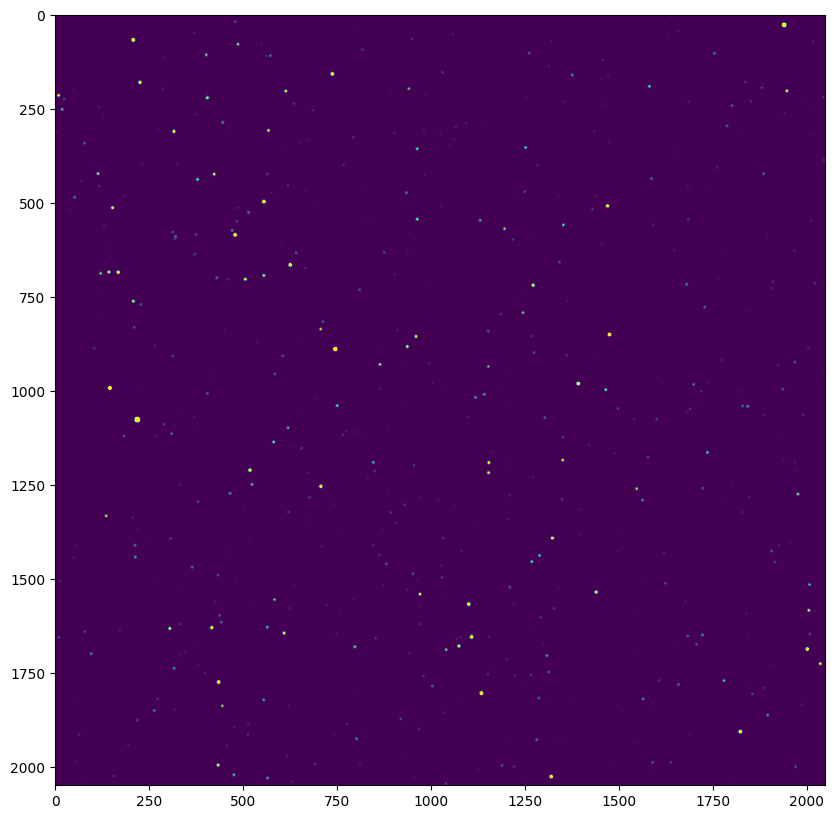

In [ ]:

# from pandorapsf import SparseWarp3d
# from scipy import sparse

mean_x, mean_y = np.random.uniform(0, 2048, size=(2, 1000))
std_x, std_y = 2, 2
image_shape = (2048, 2048)
nstddevs = 8
R, C = np.mgrid[-nstddevs : nstddevs + 1, -nstddevs : nstddevs + 1]

data = gaussian_2d(
    R[:, :, None],
    C[:, :, None],
    mean_x % 1,
    mean_y % 1,
    np.atleast_1d(std_x),
    np.atleast_1d(std_y),
)


s = SparseWarp3D(
    data,
    R[:, :, None] + np.floor(mean_x),
    C[:, :, None] + np.floor(mean_y),
    image_shape,
)

# True flux
w = 10**np.random.normal(size=mean_x.shape[0])
fake_data = s.dot(w)[0]

plt.figure(figsize=(10, 10))
plt.imshow(fake_data, vmin=0, vmax=1)

# bunk

In [21]:
# # make scene model
# from scipy.stats import multivariate_normal
# # var = multivariate_normal(mean=[c1,c2], cov=[[1,0],[0,1]])

# # model = np.zeros([cutout_size, cutout_size, len(cat)])
# model_grid = [[(i, j) for j in range(int(vda.naxis1.value))] for i in range(int(vda.naxis2.value))]
# # fluxes = tessda.mag_to_flux(gaia_cat['gmag'].value)
# # fluxes = gaia_cat['gflux'].value  # use gaia g flux
# fluxes = vda.flux_from_mag(cat_warp['gmag'].value)  # use gaia g flux

# # arr = var.pdf(list(zip(np.arange(0,1,.05), np.arange(0,1,.05))))
# model = [multivariate_normal(mean=[pix_x[i],pix_y[i]], cov=[[1,0],[0,1]]).pdf(model_grid) * fluxes[i] for i in range(len(cat_warp))]


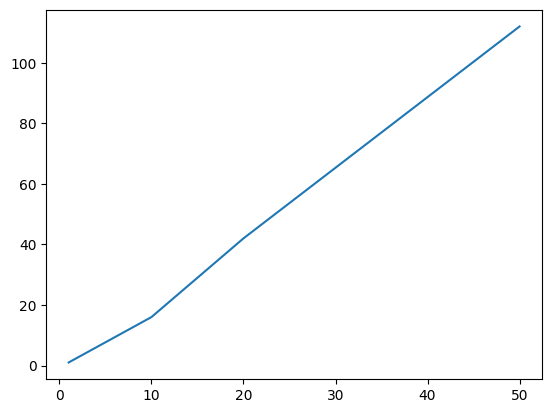

In [26]:
# # lets figure out how to build the model without breaking things
# import time
# start = time.time()

# cuts = np.array([1, 10, 20, 50, 100])
# times_arr = np.zeros_like(cuts)
# times_add = np.zeros_like(cuts)

# for i in range(len(cuts)):
#     model = [multivariate_normal(mean=[pix_x[i],pix_y[i]], cov=[[1,0],[0,1]]).pdf(model_grid) * fluxes[i] for i in range(cuts[i])]
#     times_arr[i] = time.time() - start




In [38]:
multivariate_normal(mean=[pix_x[i],pix_y[i]], cov=[[1,0],[0,1]]).pdf(model_grid) * fluxes[i].value

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
times_add = np.zeros_like(cuts)

start = time.time()
model_add = np.zeros([2048,2048])
for cut in range(len(cuts)):
    for i in range(cuts[cut]):
        model_add += multivariate_normal(mean=[pix_x[i],pix_y[i]], cov=[[1,0],[0,1]]).pdf(model_grid) * fluxes[i].value
    times_add[cut] = time.time() - start

In [33]:
np.shape(model)
np.shape(np.zeros([2048,2048]))

(2048, 2048)

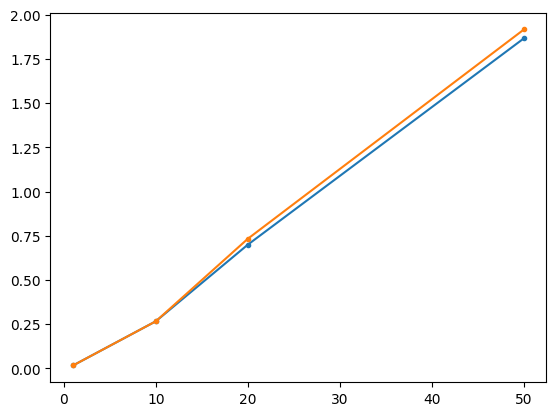

In [42]:
plt.plot(cuts,times/60, marker='.')
plt.plot(cuts,times_add/60, marker='.')
plt.show()